<a href="https://colab.research.google.com/github/duongtrung/Pytorch-tutorials/blob/main/14_pytorch_multivariate_timeseries_forecasting_LSTM_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

In [1]:
# dataset: https://finance.yahoo.com/quote/GE/history/
# select Max in the Time Period if you want to get all datasets until your current date

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

C:\Users\Lena\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("data/GE-3months.csv")

In [4]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,107.879997,108.279999,103.690002,103.849998,103.414063,8984300
1,2021-10-28,103.389999,105.379997,103.099998,105.260002,104.818161,5910800
2,2021-10-29,104.949997,105.239998,104.120003,104.870003,104.429794,5618700
3,2021-11-01,105.760002,106.769997,105.279999,106.230003,105.784088,4887100
4,2021-11-02,106.339996,107.139999,105.300003,106.690002,106.242149,4480800


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,83.730675,84.845635,82.511746,83.657143,83.445877,6.696986e+06
std,13.882652,13.905495,13.732063,13.747321,13.627205,2.945638e+06
min,61.000000,61.160000,59.930000,61.090000,61.014286,3.269000e+06
25%,72.885000,73.830000,71.139999,72.725000,72.679544,4.980125e+06
50%,80.029999,81.525002,79.110000,80.509998,80.314315,6.147600e+06
75%,94.945001,96.064999,93.650002,94.922501,94.610777,7.606150e+06
max,114.730003,116.169998,110.480003,111.290001,110.822838,2.875490e+07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [7]:
# separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [8]:
train_dates.head(5)

0   2021-10-27
1   2021-10-28
2   2021-10-29
3   2021-11-01
4   2021-11-02
Name: Date, dtype: datetime64[ns]

In [9]:
# variables for training
cols = list(df)[1:2] # ['Open', 'High', 'Low', 'Close', 'Adj Close']

In [10]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

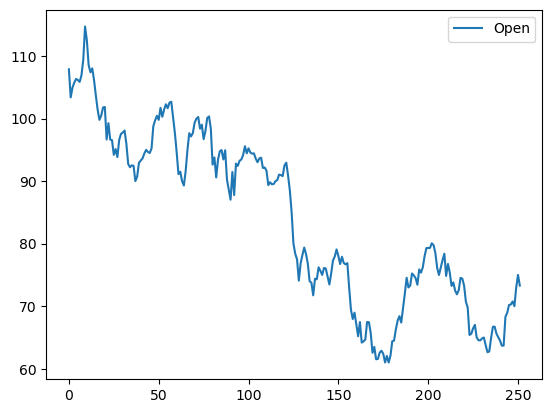

In [11]:
df_for_training.plot.line()

In [12]:
scaler =  StandardScaler() #RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [13]:
df_for_training_scaled.shape

(252, 1)

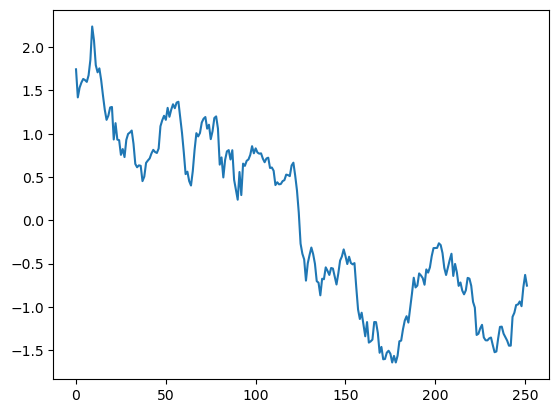

In [14]:
plt.plot(df_for_training_scaled)
plt.show()

In [15]:
#np.savetxt("data/GE_3months_scaled.csv", df_for_training_scaled, delimiter=',')

In [16]:
##splitting dataset into train and test split for time series data
training_size = int(len(df_for_training_scaled)*0.65)
test_size = len(df_for_training_scaled)-training_size
train_data,test_data = df_for_training_scaled[0:training_size,:], df_for_training_scaled[training_size:len(df_for_training_scaled),:]

In [17]:
train_data.shape, test_data.shape

((163, 1), (89, 1))

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
class SequenceDataset(Dataset):
    def __init__(self,data,past_len = 10):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.past_len = past_len
        
    def __len__(self):
        return len(self.data)-self.past_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.past_len] , self.data[index+self.past_len]


train_dataset = SequenceDataset(train_data) 
test_dataset = SequenceDataset(test_data) 

In [20]:
len(train_dataset)

152

In [21]:
train_dataset[0]

(tensor([1.7430, 1.4189, 1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527,
         2.2374]),
 tensor(2.0764))

In [22]:
train_dataset[1]

(tensor([1.4189, 1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527, 2.2374,
         2.0764]),
 tensor(1.7914))

In [23]:
train_dataset[2]

(tensor([1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527, 2.2374, 2.0764,
         1.7914]),
 tensor(1.7084))

In [24]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size , drop_last=False)

In [25]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = hidden_size, num_layers= num_layers, dropout=0, bidirectional=False)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0

In [26]:
input_dim = 1 
hidden_size = 20
num_layers = 3

In [27]:
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [30]:
from torchsummary import summary
summary(model)

ModuleNotFoundError: No module named 'torchsummary'